In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime


In [10]:
# Load datasets
fraud_data = pd.read_csv('/home/ayalk94/Documents/GitHub/Enhanced-Fraud-Detection--for-E-Commerce-and-Banking-using-ML-and-Geolocation/data/Data/Fraud_Data.csv')
ip_data = pd.read_csv('/home/ayalk94/Documents/GitHub/Enhanced-Fraud-Detection--for-E-Commerce-and-Banking-using-ML-and-Geolocation/data/Data/IpAddress_to_Country.csv')

### 1. Handle Missing Values

### 2. Data Cleaning

In [13]:
# Remove duplicates
fraud_data.drop_duplicates(inplace=True)

In [14]:
# Correct data types - Convert 'signup_time' and 'purchase_time' to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

### 3. Exploratory Data Analysis (EDA)

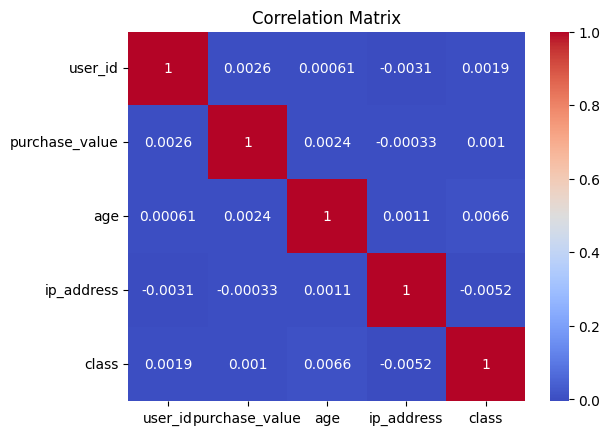

In [16]:
# Filter numeric columns only for the correlation matrix
numeric_columns = fraud_data.select_dtypes(include=[np.number])

# Bivariate Analysis - Analyze correlation between features and target (class: fraud/not fraud)
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### 4. Merge Datasets for Geolocation Analysis

In [18]:
# Ensure that all IP addresses are strings and handle missing values
fraud_data['ip_address'] = fraud_data['ip_address'].fillna('0.0.0.0').astype(str)

# Convert IP addresses to integer format in the fraud dataset
fraud_data['ip_address_int'] = fraud_data['ip_address'].apply(
    lambda x: int(''.join([f'{int(i):08b}' for i in x.split('.')]), 2)
)

# Convert IP ranges to integer format in the IP dataset
ip_data['lower_bound_ip_address'] = ip_data['lower_bound_ip_address'].fillna('0.0.0.0').astype(str)
ip_data['upper_bound_ip_address'] = ip_data['upper_bound_ip_address'].fillna('0.0.0.0').astype(str)

ip_data['lower_bound_ip_address_int'] = ip_data['lower_bound_ip_address'].apply(
    lambda x: int(''.join([f'{int(i):08b}' for i in x.split('.')]), 2)
)
ip_data['upper_bound_ip_address_int'] = ip_data['upper_bound_ip_address'].apply(
    lambda x: int(''.join([f'{int(i):08b}' for i in x.split('.')]), 2)
)

# Merge the two datasets based on the IP address range
fraud_data = pd.merge(
    fraud_data, ip_data, 
    how='left', 
    left_on='ip_address_int', 
    right_on='lower_bound_ip_address_int'
)


### 5. Feature Engineering

In [19]:
# Transaction frequency - Number of transactions made by each user
fraud_data['transaction_count'] = fraud_data.groupby('user_id')['user_id'].transform('count')

# Transaction velocity - Time difference between signup and purchase
fraud_data['transaction_velocity'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()

# Time-based features - Hour of the day and day of the week
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek

### 6. Normalization and Scaling

In [20]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['purchase_value', 'transaction_velocity', 'transaction_count']
fraud_data[numerical_features] = scaler.fit_transform(fraud_data[numerical_features])


### 7. Encode Categorical Features

In [21]:
# Encode categorical features - One hot encoding for 'source', 'browser', and 'sex'
fraud_data = pd.get_dummies(fraud_data, columns=['source', 'browser', 'sex'], drop_first=True)

# Final look at the preprocessed data
print(fraud_data.head())

# Save the cleaned and processed data to a new CSV file
fraud_data.to_csv('Fraud_Data_Preprocessed.csv', index=False)


   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11       -0.160204   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54       -1.142592   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45       -1.197169   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50        0.385567   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53        0.112681   

       device_id  age        ip_address  class   ip_address_int  \
0  QVPSPJUOCKZAR   39   732758368.79972      0   96044104890468   
1  EOGFQPIZPYXFZ   53  350311387.865908      0  367328113800820   
2  YSSKYOSJHPPLJ   53  2621473820.11095      1   42950227077975   
3  ATGTXKYKUDUQN   41  3840542443.91396      0  503387579180292   
4  NAUITBZFJKHWW   45  415583117.452712      0  217885241698408   

  lower_bound_ip_address  ... transaction_velocity hour_of_day  day_of_week  \
0                    NaN  ...            -0.136057           2            5   
1                 